In [1]:
"""
Working on a big refactor here...
moving towards vrAnalysis2

Objectives:
- Build dataclass structure for imaging and behavior sessions that I can operate on
across datatypes - I want to run the same code on my data and external data
- Simplify analyses by building a set of functions that can be called on these dataclasses
instead of extending analysis classes for each kind of analysis
- Rewrite standard scripts to do analyses with this new refactor


I should think about the key requirements for analyzing behavior and imaging data for
vr navigation and structure around that. Things that I do:

Basic data handling:
- Load spiking data
- Load behavior data (position, speed, etc)
- Load ROI data

Processing:
- Make a spkmap
- Process spkmaps
- Filter and sort ROIs by tracked (or other criteria, like plane_idx...)
"""


"""
Ideas:
An analysis object which can be loaded that isn't necessarily connect to any data. You can pass in a list
of data objects to it and it will run the analysis on all of them. This way I can run the same analysis on
my data and external data, compare within a mouse, across mice, etc.

There can be a "flag" for same mice with tracker, in which case it can perform special operations like aligning
ROIs across sessions by tracked ROI etc. 
"""

"""
Updates / Work in progress:
- I've got the b2session working. I think it's good. There might be more to add or reorganize, but essentially it's
  ready to go because it can find the onedata, load spks in a clever way, and has a few other tools for loading. 
- Now I think I can just keep working on everything that comes after this... e.g. on the analysis class side of things
  which might need a lot of refactoring (or maybe not???)
- The registration stuff will be nice to refactor to this method, but for now I can hack it and just use both I guess?
"""

print()

In [35]:
%reload_ext autoreload
%autoreload 2

import random
import numpy as np
from matplotlib import pyplot as plt
from syd import make_viewer

from vrAnalysis2.helpers import Timer, tic, toc
from vrAnalysis2.helpers import concat_with_spacer
from vrAnalysis2.metrics import FractionActive
from vrAnalysis2.sessions import create_b2session
from vrAnalysis2.processors.spkmaps import SpkmapProcessor, SpkmapParams
from vrAnalysis2.tracking import Tracker
from vrAnalysis2.multisession import MultiSessionSpkmaps
from vrAnalysis2.database import get_database
sessiondb = get_database("vrSessions")

session = random.choice(sessiondb.iter_sessions(imaging=True, mouseName="ATL076"))
smp = SpkmapProcessor(session)

In [36]:
track = Tracker(session.mouse_name)

In [37]:
mss = MultiSessionSpkmaps(track)

In [60]:
env_stats = mss.env_stats()
print(env_stats)

envnum, idx_ses = mss.env_idx_ses_selector(envmethod="least", sesmethod="all")
# idx_ses = idx_ses[0:10]
print(envnum, idx_ses)

{1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 3: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
3 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [61]:
spkmaps, extras = mss.get_spkmaps(envnum=envnum, idx_ses=idx_ses, average=False, tracked=True)
avg_spkmaps = [s.mean(axis=1) for s in spkmaps]
fraction_active = [FractionActive.compute(s, activity_axis=2, fraction_axis=1) for s in spkmaps]

In [67]:
ref_session = 4
rel_threshold = 0.3
idx_reliable = extras["reliability"][ref_session] > rel_threshold

frac_threshold = 0.1
idx_active = fraction_active[ref_session] > frac_threshold

idx_selected = idx_active & idx_reliable
pfidx = np.argsort(extras["pfloc"][ref_session][idx_selected])

# Filter out unreliable ROIs
selected_spkmaps = [s[idx_selected] for s in avg_spkmaps]

# Stack horizontally with a spacer
spacer_width = 5 # in position bins
spacer = np.zeros((idx_selected.sum(), spacer_width,))
stacked_spkmaps = concat_with_spacer(selected_spkmaps, spacer)[pfidx]

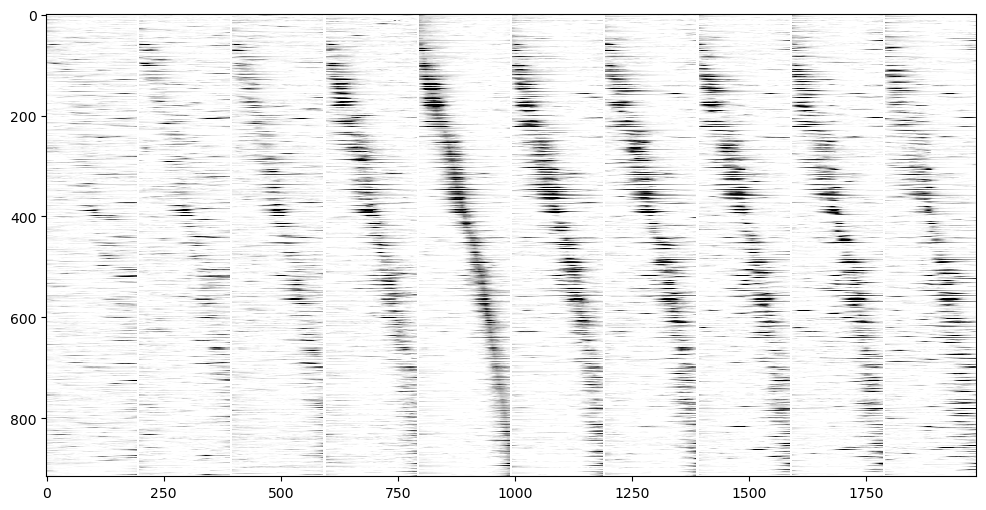

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(stacked_spkmaps, aspect="auto", cmap="gray_r", vmin=0, vmax=3, interpolation="none")
plt.show()

In [3]:
# TODO LIST
# - Need to add the auxiliary methods like reliability and frame behavior etc